# IS-02 Machine Learning - Data and Web Science
## Final Project
## Problem 2 - Regression
### <i>Avgitidis Konstantinos AM: 65</i>

In [1]:
#importing necessary libraries
import logging
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from time import time
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

For problem 2, since we are trying to calculate the fuel cost per 12000 miles, we clearly
have to deal with a regression problem so first lets take a look into
our data and figure out how to process them.

In [2]:
X = pd.read_csv("fuel_emissions.csv")
X.head()

/home/hydone/anaconda3/envs/myenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,file,year,manufacturer,model,description,euro_standard,tax_band,transmission,transmission_type,engine_capacity,...,thc_emissions,co_emissions,nox_emissions,thc_nox_emissions,particulates_emissions,fuel_cost_12000_miles,standard_12_months,standard_6_months,first_year_12_months,first_year_6_months
0,Part_A_Euro_IV_may2005.csv,2005,BMW,1 Series E87,116i,4,NaN,M5,Manual,1596.0,...,NaN,260.0,35.0,NaN,NaN,1158.0,NaN,NaN,NaN,NaN
1,Part_A_Euro_IV_may2005.csv,2005,BMW,1 Series E87,118d - from March 2005,4,NaN,M6,Manual,1995.0,...,NaN,290.0,166.0,NaN,17.0,422.0,NaN,NaN,NaN,NaN
2,Part_A_Euro_IV_may2005.csv,2005,BMW,1 Series E87,118d - up to February 2005,4,NaN,M6,Manual,1995.0,...,NaN,319.0,166.0,NaN,21.0,422.0,NaN,NaN,NaN,NaN
3,Part_A_Euro_IV_may2005.csv,2005,BMW,1 Series E87,118i,4,NaN,M5,Manual,1995.0,...,NaN,511.0,7.0,NaN,NaN,1128.0,NaN,NaN,NaN,NaN
4,Part_A_Euro_IV_may2005.csv,2005,BMW,1 Series E87,118i,4,NaN,A6,Automatic,1995.0,...,NaN,383.0,15.0,NaN,NaN,1206.0,NaN,NaN,NaN,NaN


Lets take a look at the types because we can see clearly we have a lot of categorical values

In [3]:
X.dtypes

file                       object
year                        int64
manufacturer               object
model                      object
description                object
euro_standard               int64
tax_band                   object
transmission               object
transmission_type          object
engine_capacity           float64
fuel_type                  object
urban_metric              float64
extra_urban_metric        float64
combined_metric           float64
urban_imperial            float64
extra_urban_imperial      float64
combined_imperial         float64
noise_level               float64
co2                         int64
thc_emissions             float64
co_emissions              float64
nox_emissions             float64
thc_nox_emissions         float64
particulates_emissions    float64
fuel_cost_12000_miles     float64
standard_12_months        float64
standard_6_months         float64
first_year_12_months      float64
first_year_6_months       float64
dtype: object

Ok now lets drop some "useless" columns. First lets remove all imperial columns since
we are going to use the metric ones for our algorithms. Next lets drop the file name,
the year since we have the euro standard column with which we can tell the range of
the manufactured year. Also since we want our models to be generic we can drop
the model and the model description columns as well.

In [4]:
#Dropping some "useless" columns
X.drop(axis=1,columns=["file","year","model","urban_imperial","extra_urban_imperial","combined_imperial","description"],inplace=True)

Next lets check if we have any NaN values

In [5]:
#check if we have any NaN values
X.isnull().sum()

manufacturer                  0
euro_standard                 0
tax_band                  25251
transmission                 10
transmission_type           341
engine_capacity               7
fuel_type                     0
urban_metric                 13
extra_urban_metric           13
combined_metric               7
noise_level                   0
co2                           0
thc_emissions             16599
co_emissions                 24
nox_emissions                70
thc_nox_emissions         27658
particulates_emissions    19912
fuel_cost_12000_miles        10
standard_12_months        29571
standard_6_months         30162
first_year_12_months      29571
first_year_6_months       31669
dtype: int64

We can clearly see that we have some columns with a lot of NaN values. We will drop
columns that have more than 40% of their values as NaN and fill the other ones with each
column's mean for non categorical columns. For categorical columns we will use method
'ffill'. There are just 10 NaN values in our target column (fuel_cost_12000_miles) so, it is
better to remove the rows that contain these values rather than filling them.

In [6]:
#Get all column names that have more than 40% NaN values.
alist = [i for i in zip(X.isnull().sum(),X.columns.values)]
columns2drop = [i[1] for i in alist if i[0] > X.shape[0]*.4]

In [7]:
X.drop(axis=1,columns=columns2drop,inplace=True)
X.dropna(axis=0,subset=["fuel_cost_12000_miles"],inplace=True)

In [8]:
#New df with dropped columns
X.head()

,manufacturer,euro_standard,transmission,transmission_type,engine_capacity,fuel_type,urban_metric,extra_urban_metric,combined_metric,noise_level,co2,co_emissions,nox_emissions,fuel_cost_12000_miles
0,BMW,4,M5,Manual,1596.0,Petrol,10.5,5.9,7.5,73.0,181,260.0,35.0,1158.0
1,BMW,4,M6,Manual,1995.0,Diesel,7.7,4.5,5.6,72.0,150,290.0,166.0,422.0
2,BMW,4,M6,Manual,1995.0,Diesel,7.7,4.5,5.6,72.0,150,319.0,166.0,422.0
3,BMW,4,M5,Manual,1995.0,Petrol,10.1,5.7,7.3,72.0,176,511.0,7.0,1128.0
4,BMW,4,A6,Automatic,1995.0,Petrol,10.7,6.1,7.8,70.0,188,383.0,15.0,1206.0


In [9]:
#moving target column to y
y = X.fuel_cost_12000_miles
X.drop(axis=1,columns="fuel_cost_12000_miles",inplace=True)

In [10]:
values = {
          "engine_capacity" : X.engine_capacity.mean(),
          "urban_metric" : X.urban_metric.mean(),
          "extra_urban_metric" : X.extra_urban_metric.mean(),
          "combined_metric" : X.combined_metric.mean(),
          "co_emissions" : X.co_emissions.mean(),
          "nox_emissions" : X.nox_emissions.mean()
          }
X.fillna(value=values,inplace=True)
X.fillna(method="ffill",inplace=True)

In [11]:
#Check if we have any nan values still left
X.isnull().sum()

manufacturer          0
euro_standard         0
transmission          0
transmission_type     0
engine_capacity       0
fuel_type             0
urban_metric          0
extra_urban_metric    0
combined_metric       0
noise_level           0
co2                   0
co_emissions          0
nox_emissions         0
dtype: int64

In [12]:
X.dtypes

manufacturer           object
euro_standard           int64
transmission           object
transmission_type      object
engine_capacity       float64
fuel_type              object
urban_metric          float64
extra_urban_metric    float64
combined_metric       float64
noise_level           float64
co2                     int64
co_emissions          float64
nox_emissions         float64
dtype: object

We will use one-hot encoding for all categorical values left in our data, creating new columns for each
unique value inside them.

In [13]:
X = pd.get_dummies(X,columns=["manufacturer","transmission","transmission_type","fuel_type"])

In [14]:
#getting dataframe's shape
X.shape

(33078, 158)

We have 158 columns (features) in our DataFrame. It is suggested to run PCA in order to reduce the dimensionality of our problem
and run our algorithms faster. 40 features are being selected and the best 10 from
the rest are also added with a Feature Union. In all our models we decided to scale our
data with Standard Scaler since regression algorithms appear to run better when the data is scaled/normalized. The
algorithms we decided to use for the regression problem were:
- LinearRegression
- RandomForestRegressor
- SGDRegressor
- MLPRegressor
- SVR

We used in total 19 different variations of the above algorithms.

The metrics we decided to use were:
- Mean Squared Error
- Mean Squared Root Error
- Mean Absolute Error
- R2

10-Fold Cross Validated Grid Search was performed on the data and the
mean scores of each variation were extracted into a pandas DataFrame.
In total we had 190 runs of our pipeline.

>Pipeline([('scale', StandardScaler()),("features", combined_features), ("estimator", RegressionAlgorithm())])

In [15]:
try:
   df = pickle.load( open( "models_gscv.p", "rb" ) )
except FileNotFoundError:

    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s %(levelname)s %(message)s')

    # This dataset is too high-dimensional. Let's do PCA:
    pca = PCA(n_components=40)

    # Maybe some original features where good, too?
    selection = SelectKBest(k=10)

    # Build estimator from PCA and Univariate selection:
    combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

    # Use combined features to transform dataset:
    X_features = combined_features.fit(X, y).transform(X)
    print("Combined space has", X_features.shape[1], "features")


    pipe = Pipeline([('scale', StandardScaler()),("features", combined_features), ("estimator", LinearRegression())])

    #Our models
    parameters = [
        {
        'estimator': [LinearRegression()],
    },
        {
        'estimator': [RandomForestRegressor()],
        'estimator__n_estimators': [20,50,100],
        'estimator__criterion': ["mse"],
        'estimator__max_depth': [None,10],
    },
        {
        'estimator': [SGDRegressor()],
        'estimator__loss': ["huber"],
        'estimator__penalty': ["l2","elasticnet"],
        'estimator__learning_rate': ["adaptive","invscaling"],
        'estimator__max_iter': [1000 ],
    },
        {
        'estimator': [MLPRegressor()],
        'estimator__activation': ["tanh","relu","logistic"],
        'estimator__solver': ["adam"],
        'estimator__learning_rate_init': [10**-3],
        'estimator__shuffle': [True,False],
    },
        {
        'estimator': [SVR()],
        'estimator__kernel': ["sigmoid","rbf"],
        'estimator__max_iter': [10**5],
    },
    ]
    scoring = ["neg_mean_absolute_error","neg_mean_squared_error","neg_root_mean_squared_error","r2"]
    if __name__ == "__main__":

        grid_search = GridSearchCV(pipe, parameters,scoring=scoring, n_jobs=-1, cv=10, refit = "neg_root_mean_squared_error",verbose=10)

        print("Performing grid search...")
        print("pipeline:", [name for name, _ in pipe.steps])
        t0 = time()
        grid_search.fit(X, y)
        print("done in %0.3fs" % (time() - t0))
        print()
        # values = [i[0] for i in grid_search.cv_results_.values()]
        # dflist.append(values)
        print("Best score: %0.3f" % grid_search.best_score_)

        # df = pd.DataFrame(dflist,columns=list(grid_search.cv_results_.keys()))
        df = pd.DataFrame(grid_search.cv_results_)
        pickle.dump(df, open( "models_gscv.p", "wb" ) )

In [16]:
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_estimator__criterion,param_estimator__max_depth,param_estimator__n_estimators,param_estimator__learning_rate,param_estimator__loss,...,split3_test_r2,split4_test_r2,split5_test_r2,split6_test_r2,split7_test_r2,split8_test_r2,split9_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,2.307495,0.048379,0.030996,0.008465,LinearRegression(),NaN,NaN,NaN,NaN,NaN,...,0.894508,0.506864,-4.671420,0.719603,0.620971,0.672088,0.608348,0.048579,1.592130,15
1,18.914201,0.603615,0.023709,0.002768,RandomForestRegressor(),mse,None,20,NaN,NaN,...,0.803020,0.540043,0.780954,0.682513,0.802621,0.899346,0.900071,0.725860,0.188289,3
2,43.256071,0.968224,0.036076,0.002150,RandomForestRegressor(),mse,None,50,NaN,NaN,...,0.800470,0.548157,0.785045,0.695328,0.798231,0.900371,0.904246,0.728336,0.190336,2
3,84.985354,1.880756,0.063278,0.007895,RandomForestRegressor(),mse,None,100,NaN,NaN,...,0.810575,0.547452,0.784982,0.699904,0.811231,0.907651,0.898041,0.737052,0.180145,1
4,12.034566,0.229606,0.015868,0.000935,RandomForestRegressor(),mse,10,20,NaN,NaN,...,0.805007,0.563034,0.781829,0.688393,0.768352,0.872280,0.860198,0.713652,0.197086,4


In [17]:
fdf = df[['params','param_estimator','mean_test_neg_mean_absolute_error','mean_test_neg_root_mean_squared_error','mean_test_neg_mean_squared_error','mean_test_r2']].copy(True)

In [18]:
fdf["params"] = fdf["params"].astype(str)

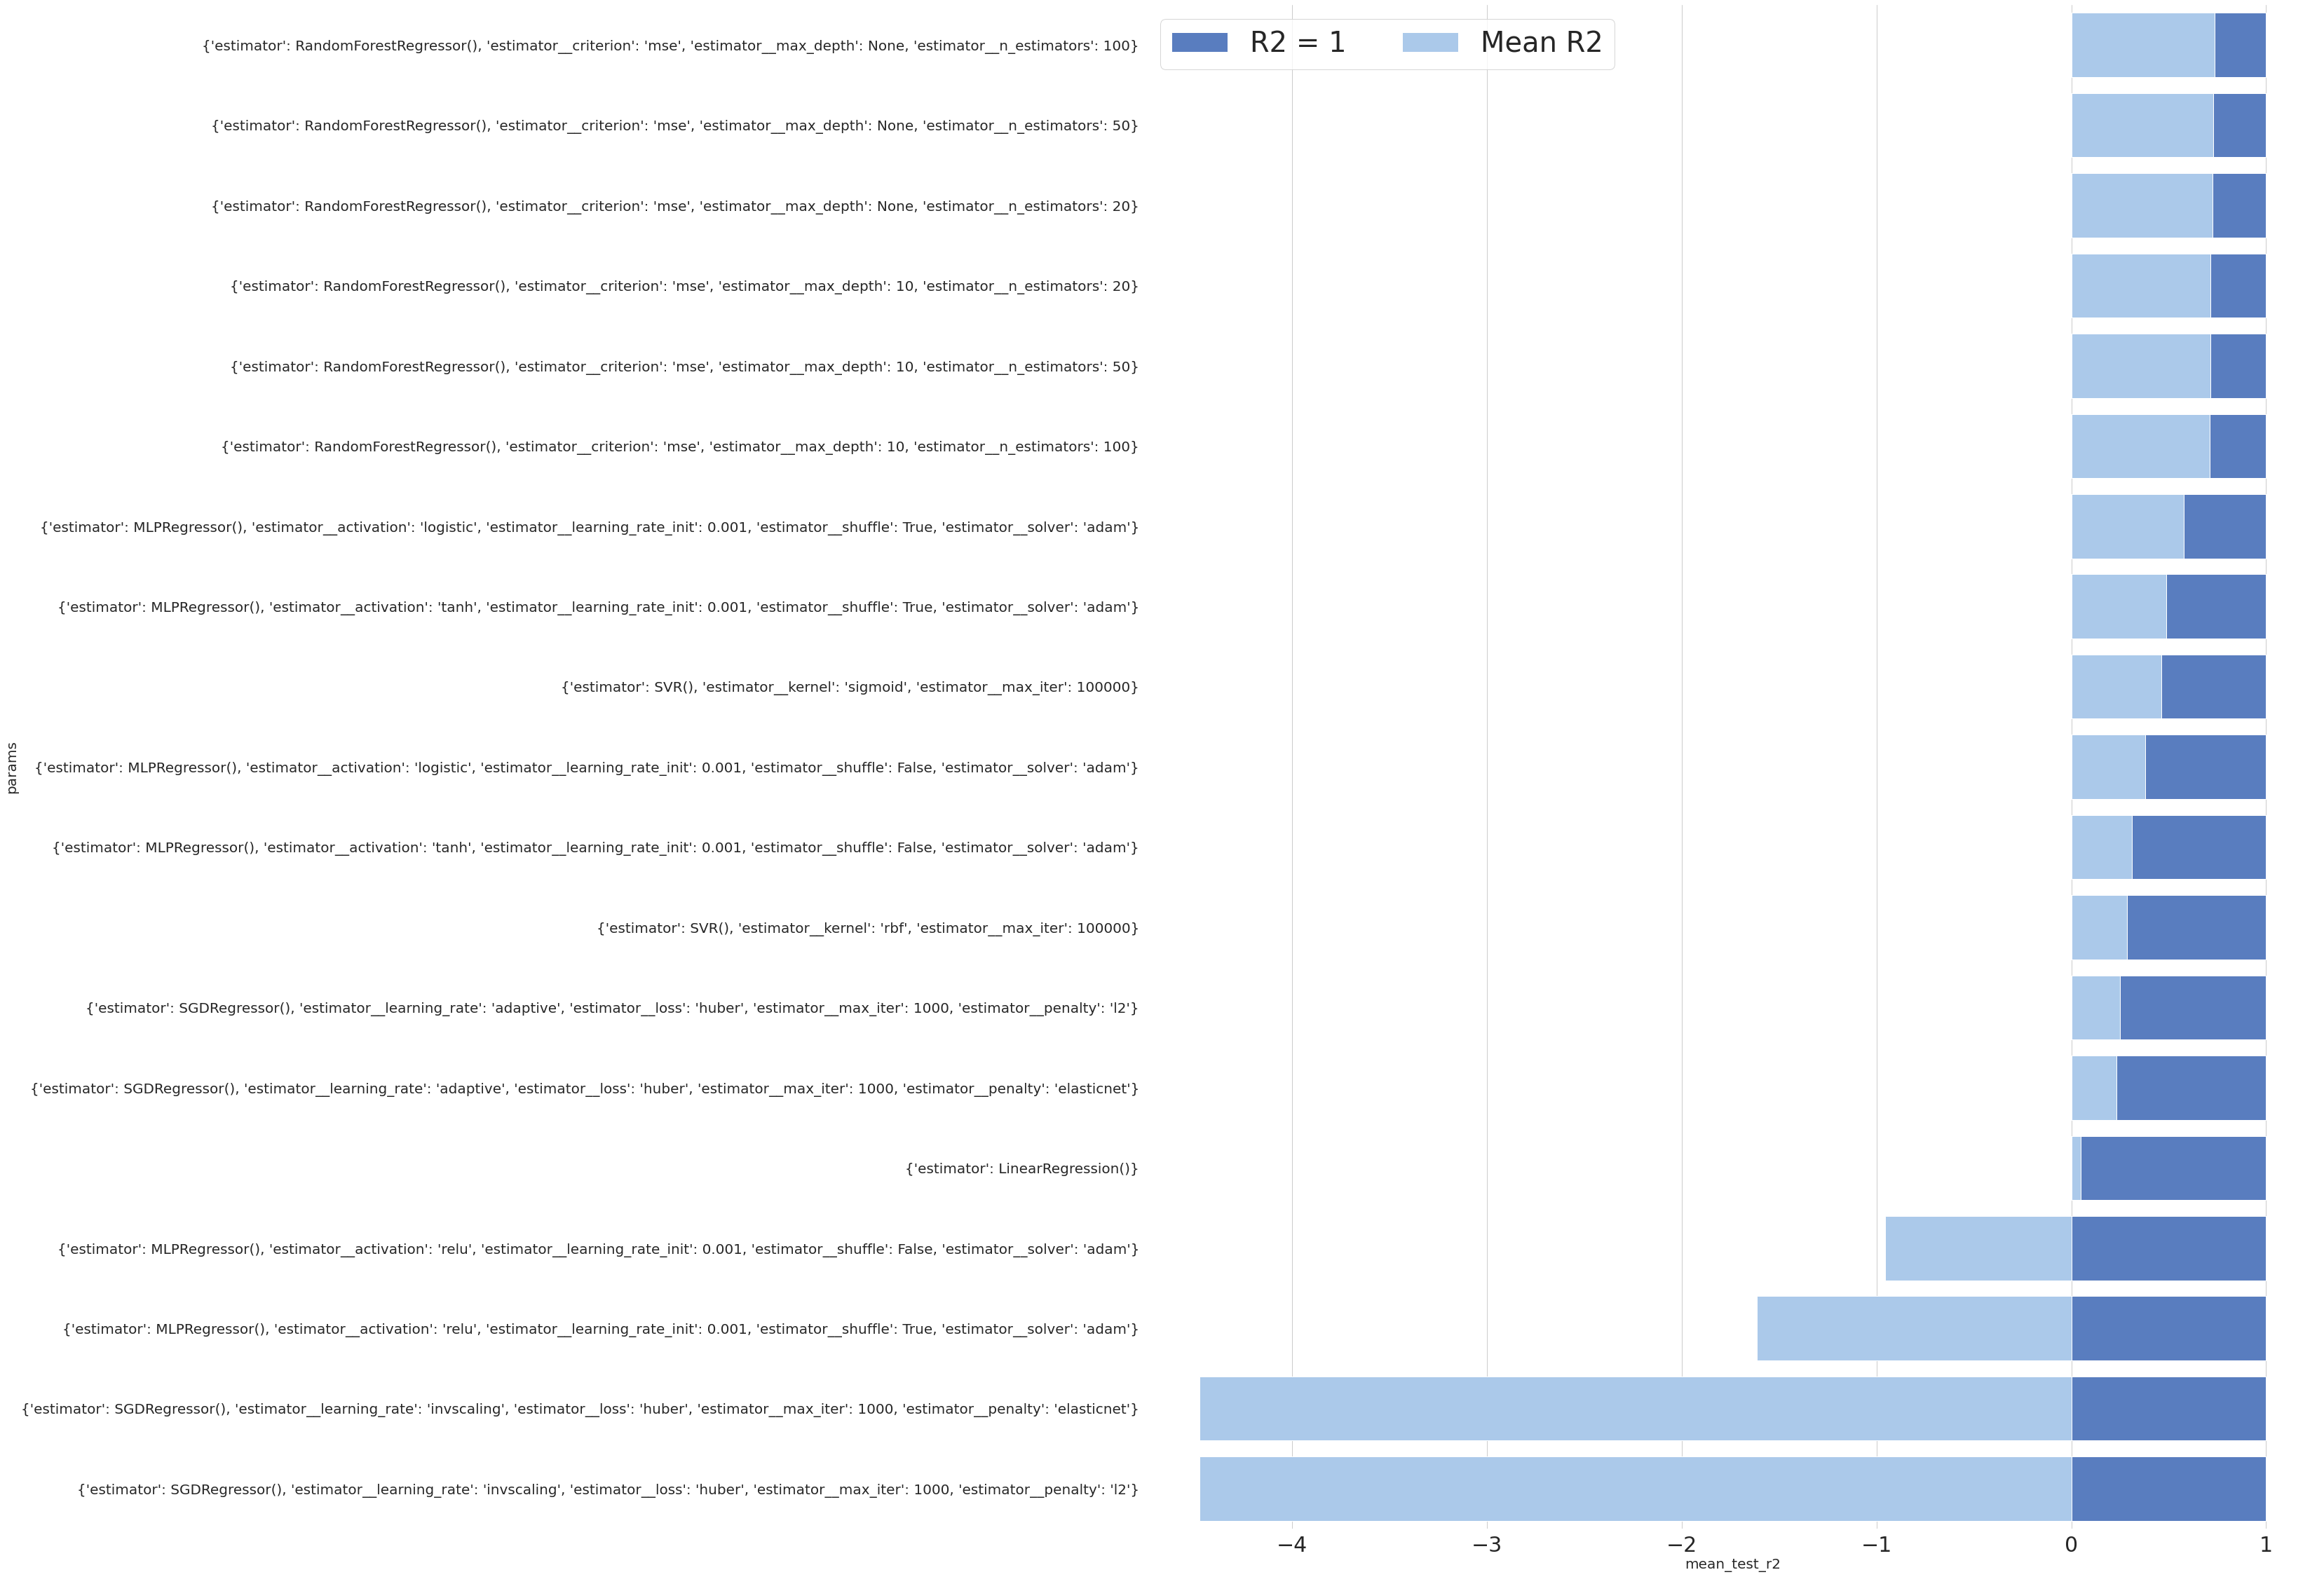

In [19]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(30, 40))
fdf.sort_values(by="mean_test_r2",ascending=False,inplace=True)
sns.set_color_codes("muted")
sns.barplot(x=[1 for _ in range(19)], y=df["params"].astype(str), data=fdf,
            label="R2 = 1", color="b")
sns.set_color_codes("pastel")
sns.barplot(x="mean_test_r2", y="params", data=fdf,
            label="Mean R2", color="b")
ax.legend(ncol=2, loc="upper left", frameon=True,fontsize=40)
ax.yaxis.label.set_size(20)
for xtick in ax.xaxis.get_major_ticks():
    xtick.label.set_fontsize(30)
for ytick in ax.yaxis.get_major_ticks():
    ytick.label.set_fontsize(20)
ax.xaxis.label.set_size(20)
sns.despine(left=True, bottom=True)

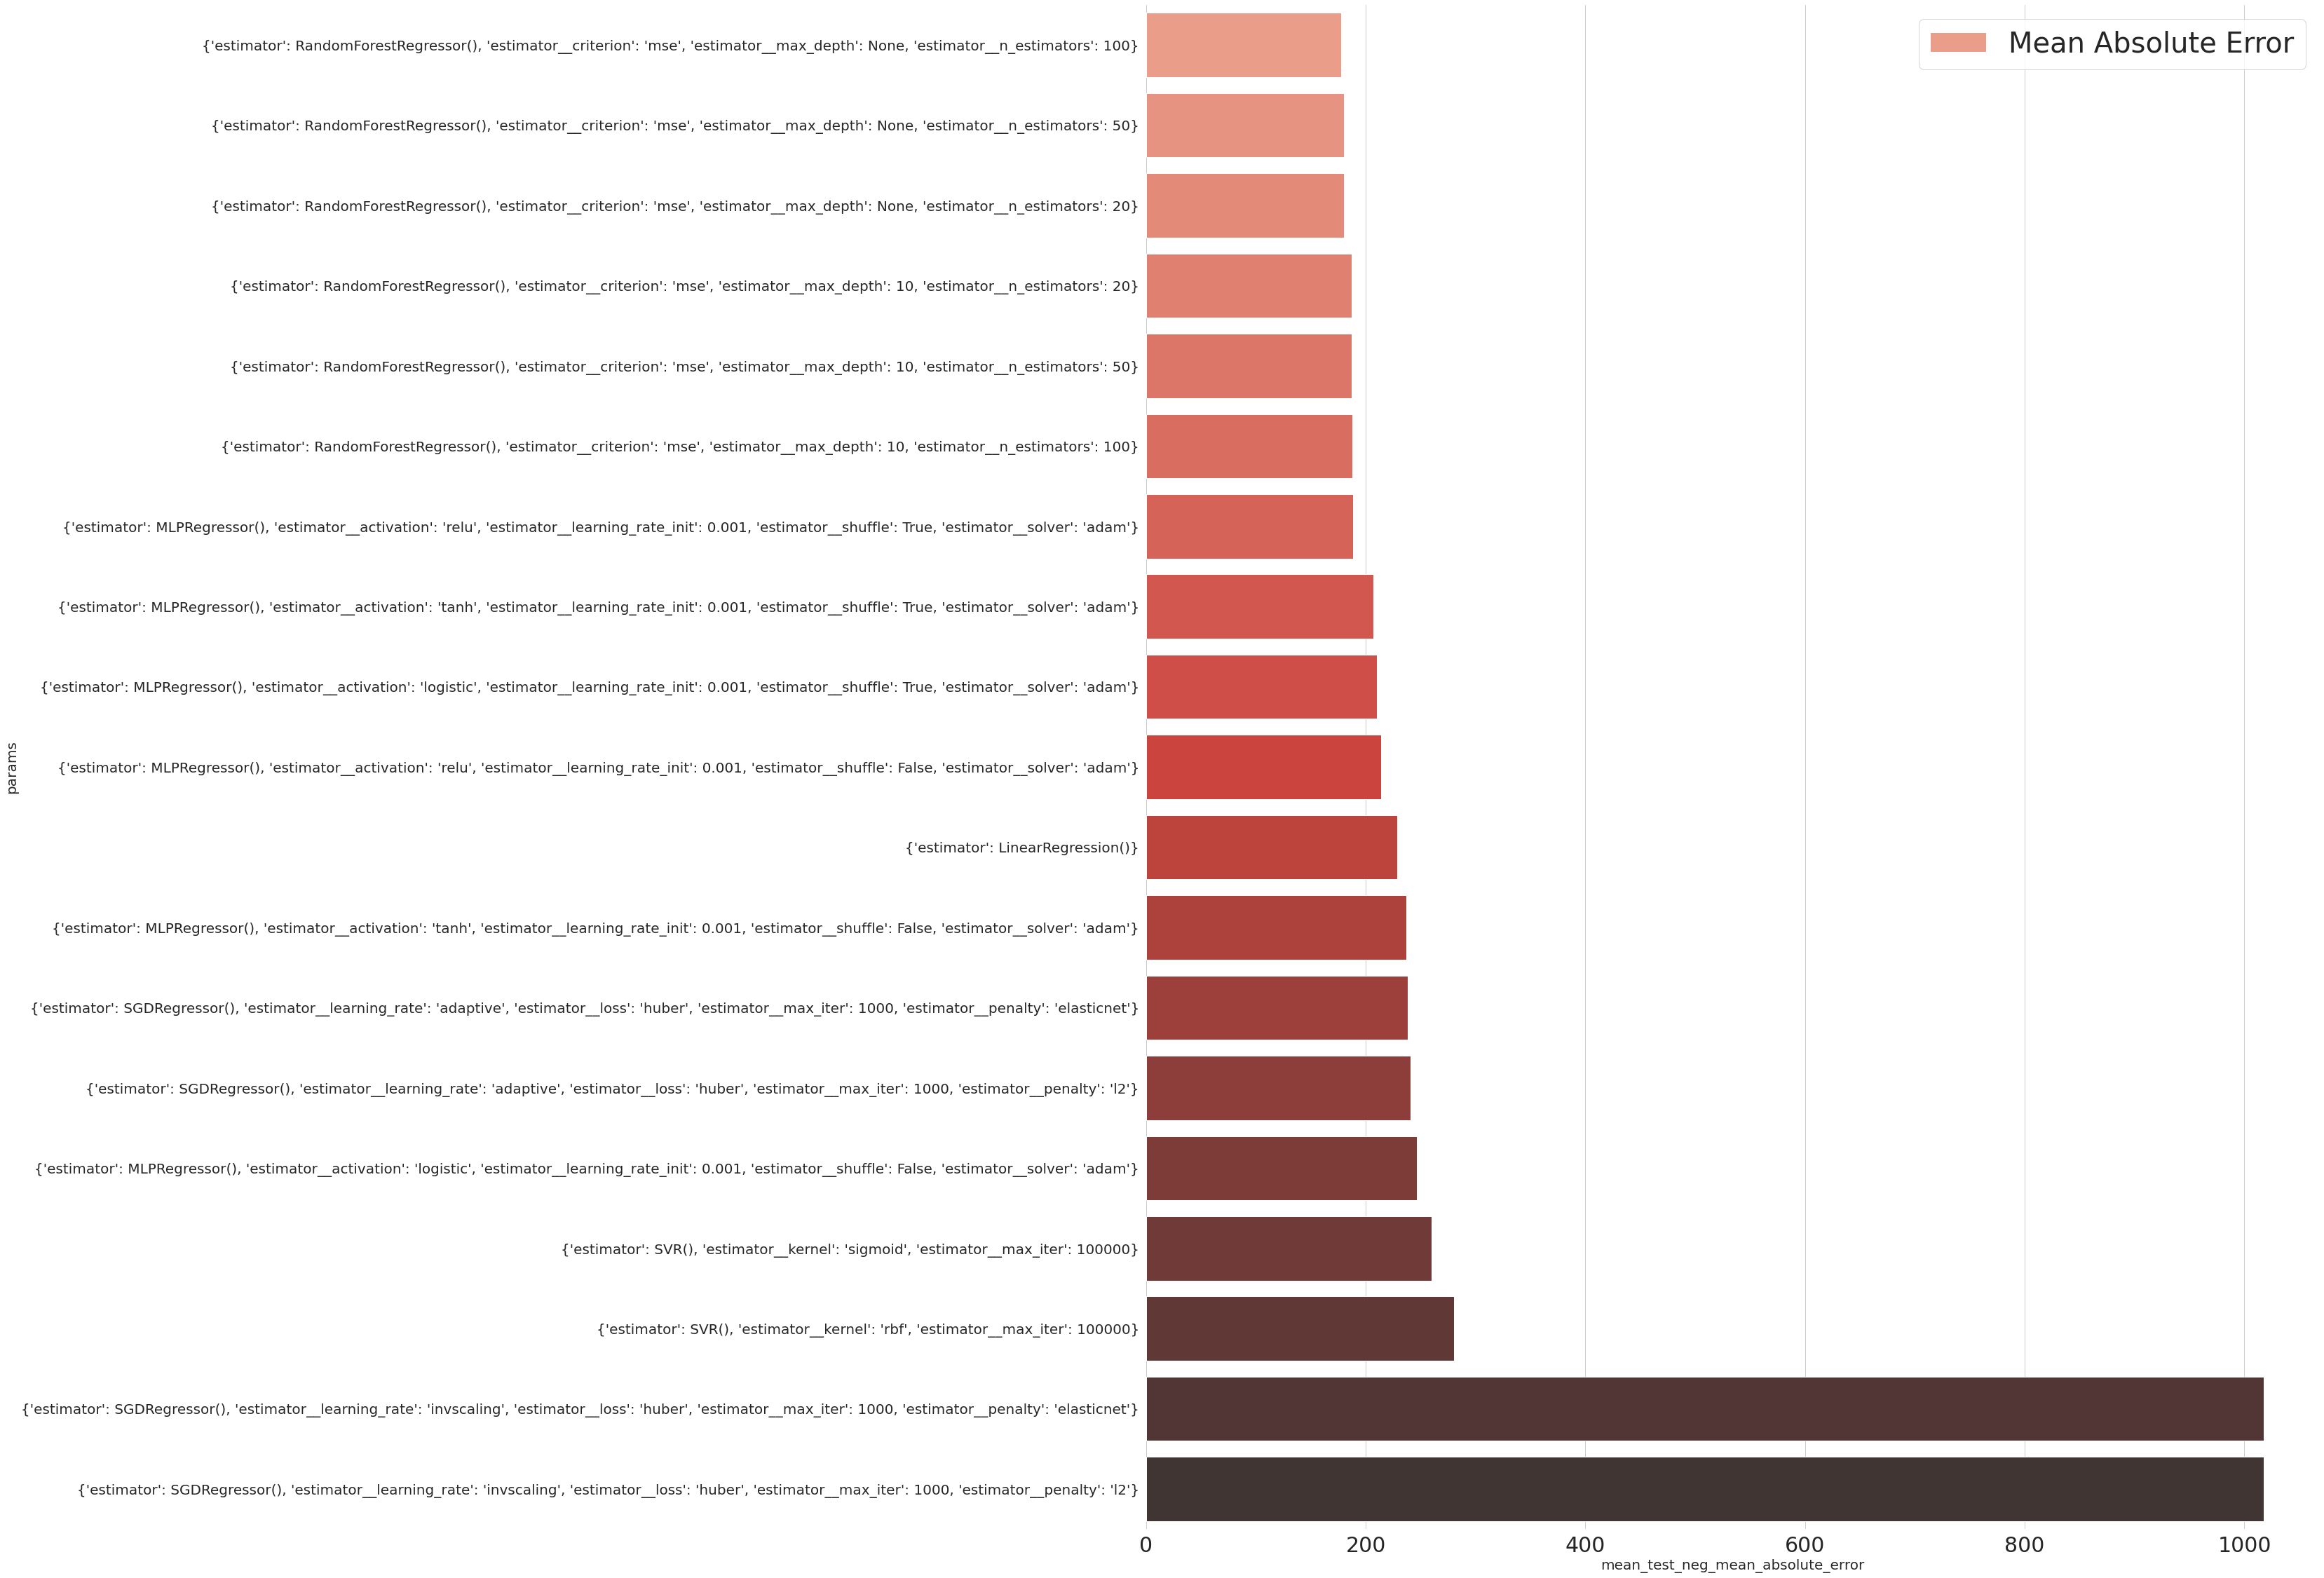

In [20]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(30, 40))
fdf.sort_values(by="mean_test_neg_mean_absolute_error",ascending=False,inplace=True)
sns.set_color_codes("pastel")
sns.barplot(x=fdf["mean_test_neg_mean_absolute_error"].abs(), y="params", data=fdf,
            label="Mean Absolute Error", palette="Reds_d")
ax.legend(ncol=1, loc="upper right", frameon=True,fontsize=40)
ax.yaxis.label.set_size(20)
for xtick in ax.xaxis.get_major_ticks():
    xtick.label.set_fontsize(30)
for ytick in ax.yaxis.get_major_ticks():
    ytick.label.set_fontsize(20)
ax.xaxis.label.set_size(20)
sns.despine(left=True, bottom=True)

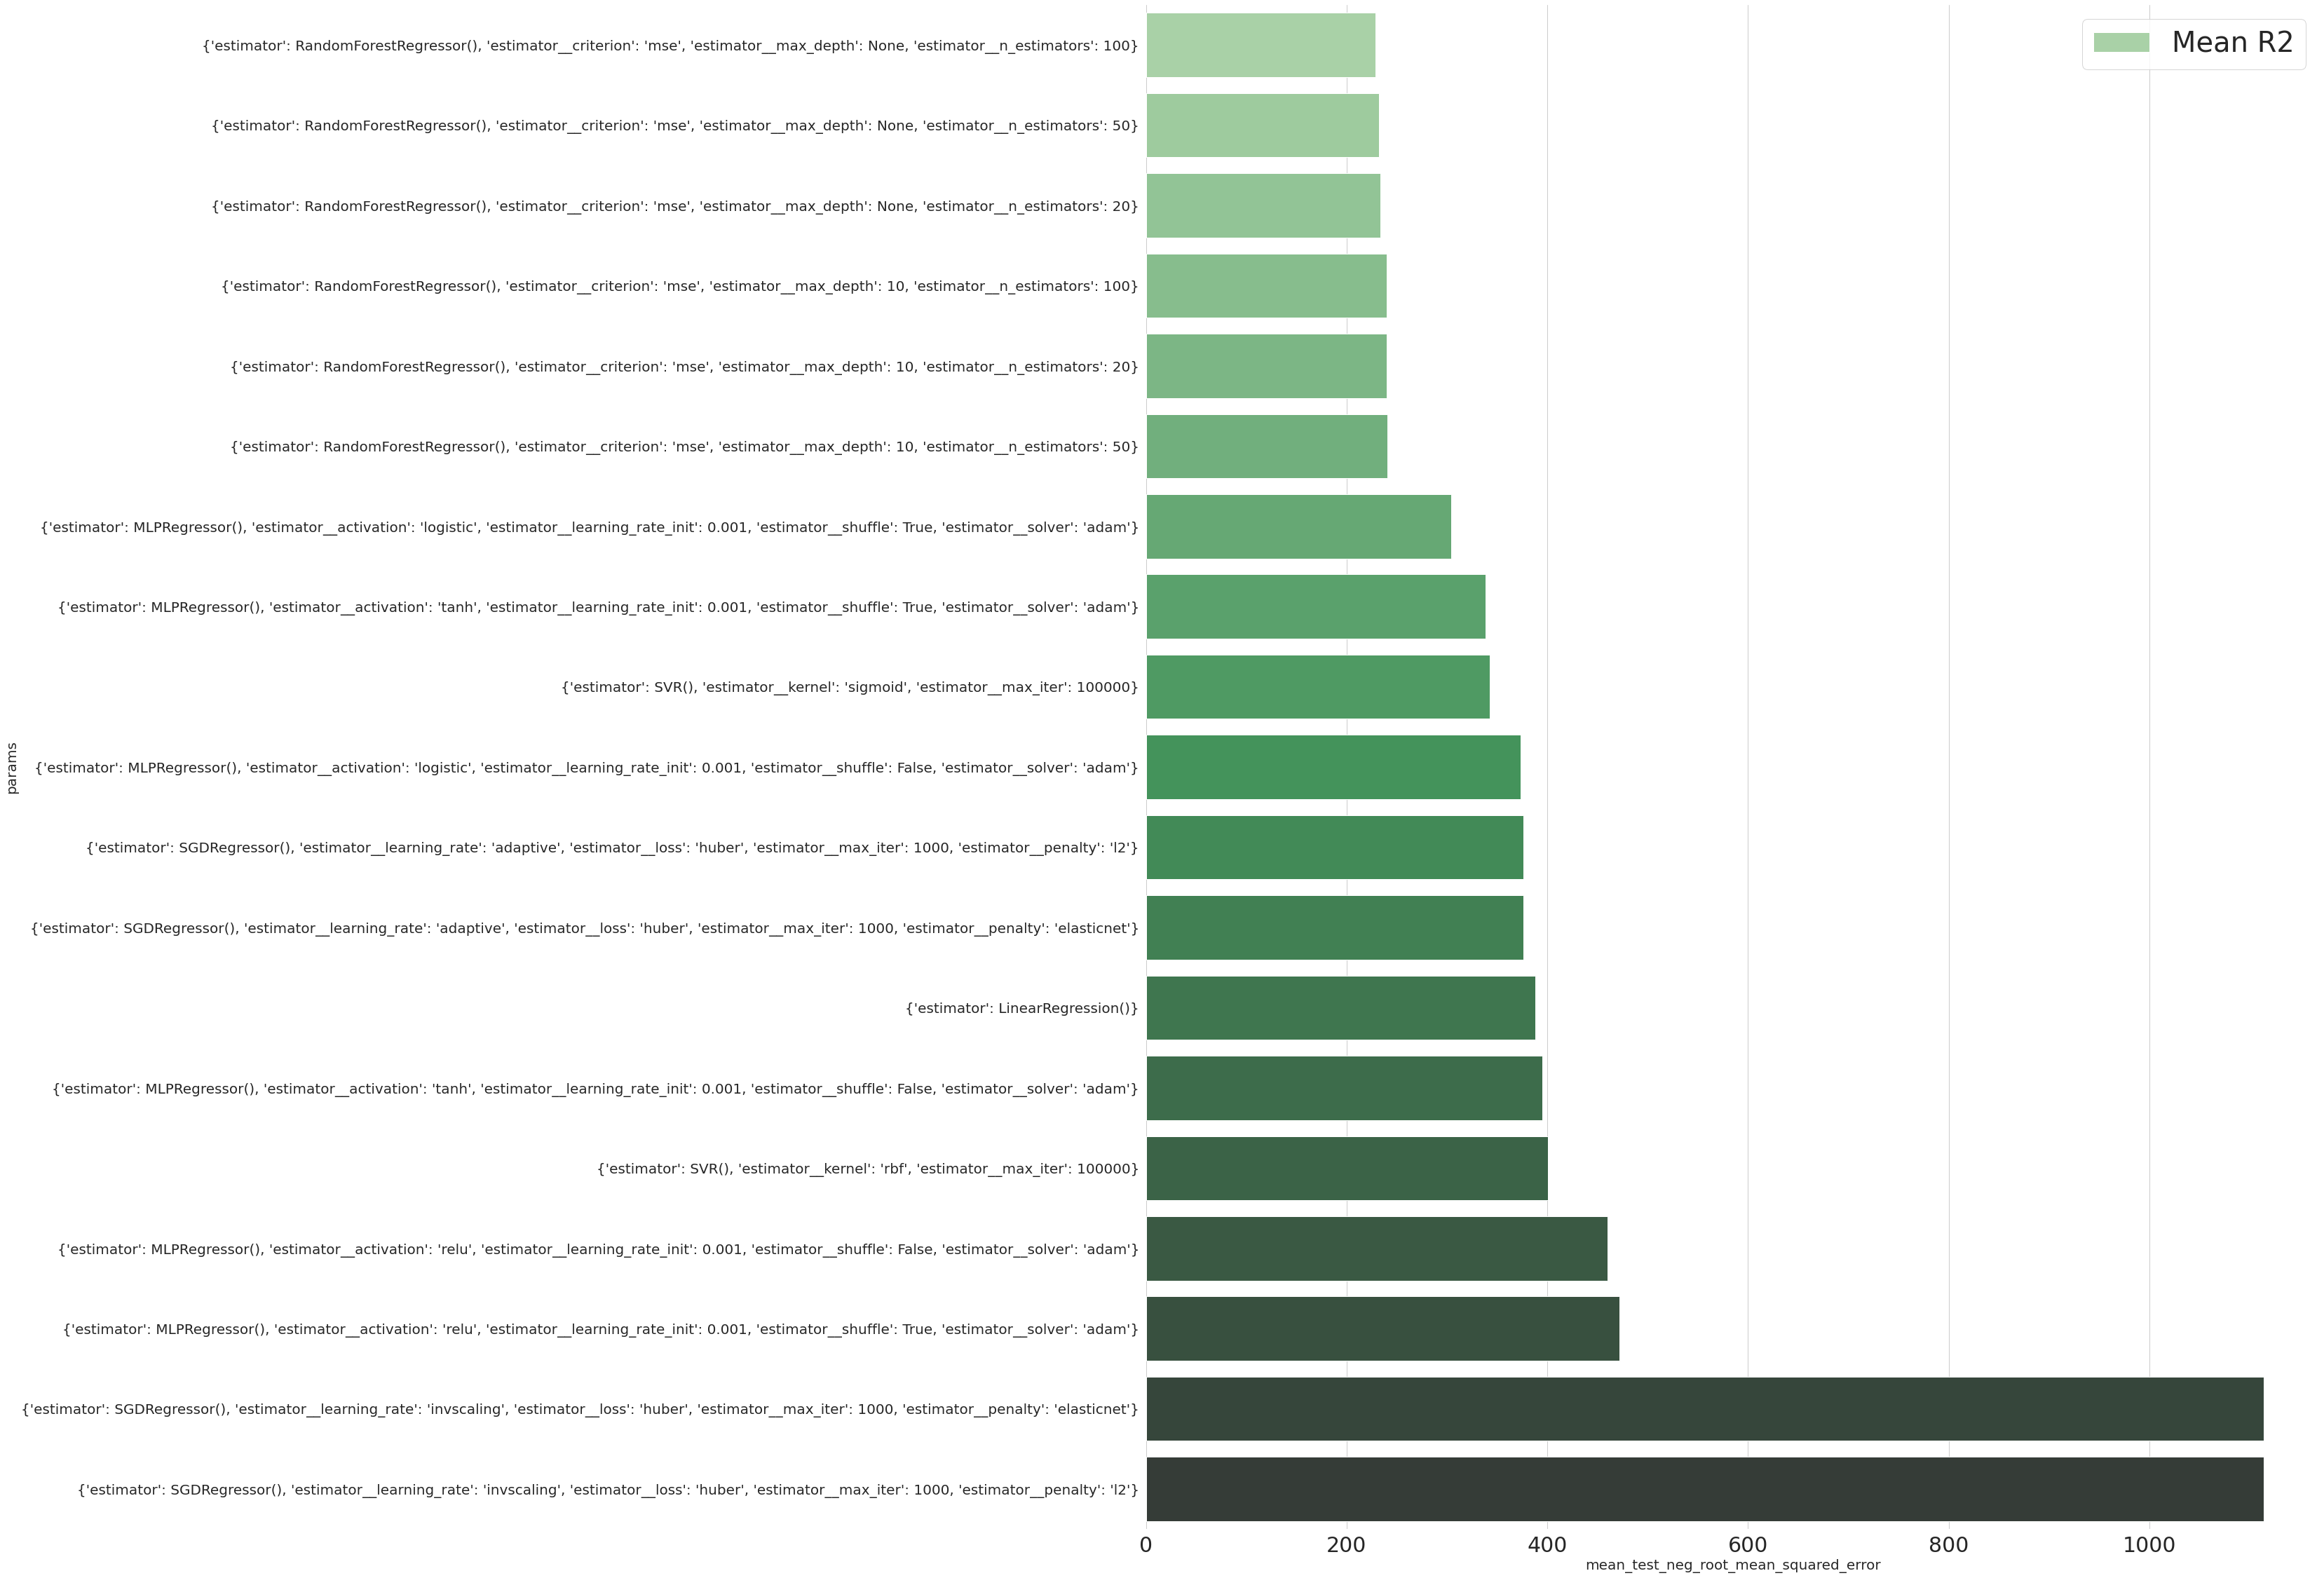

In [21]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(30, 40))
fdf.sort_values(by="mean_test_neg_root_mean_squared_error",ascending=False,inplace=True)
sns.set_color_codes("pastel")
sns.barplot(x=fdf["mean_test_neg_root_mean_squared_error"].abs(), y="params", data=fdf,
            label="Mean R2", palette="Greens_d")
ax.legend(ncol=1, loc="upper right", frameon=True,fontsize=40)
ax.yaxis.label.set_size(20)
for xtick in ax.xaxis.get_major_ticks():
    xtick.label.set_fontsize(30)
for ytick in ax.yaxis.get_major_ticks():
    ytick.label.set_fontsize(20)
ax.xaxis.label.set_size(20)
sns.despine(left=True, bottom=True)

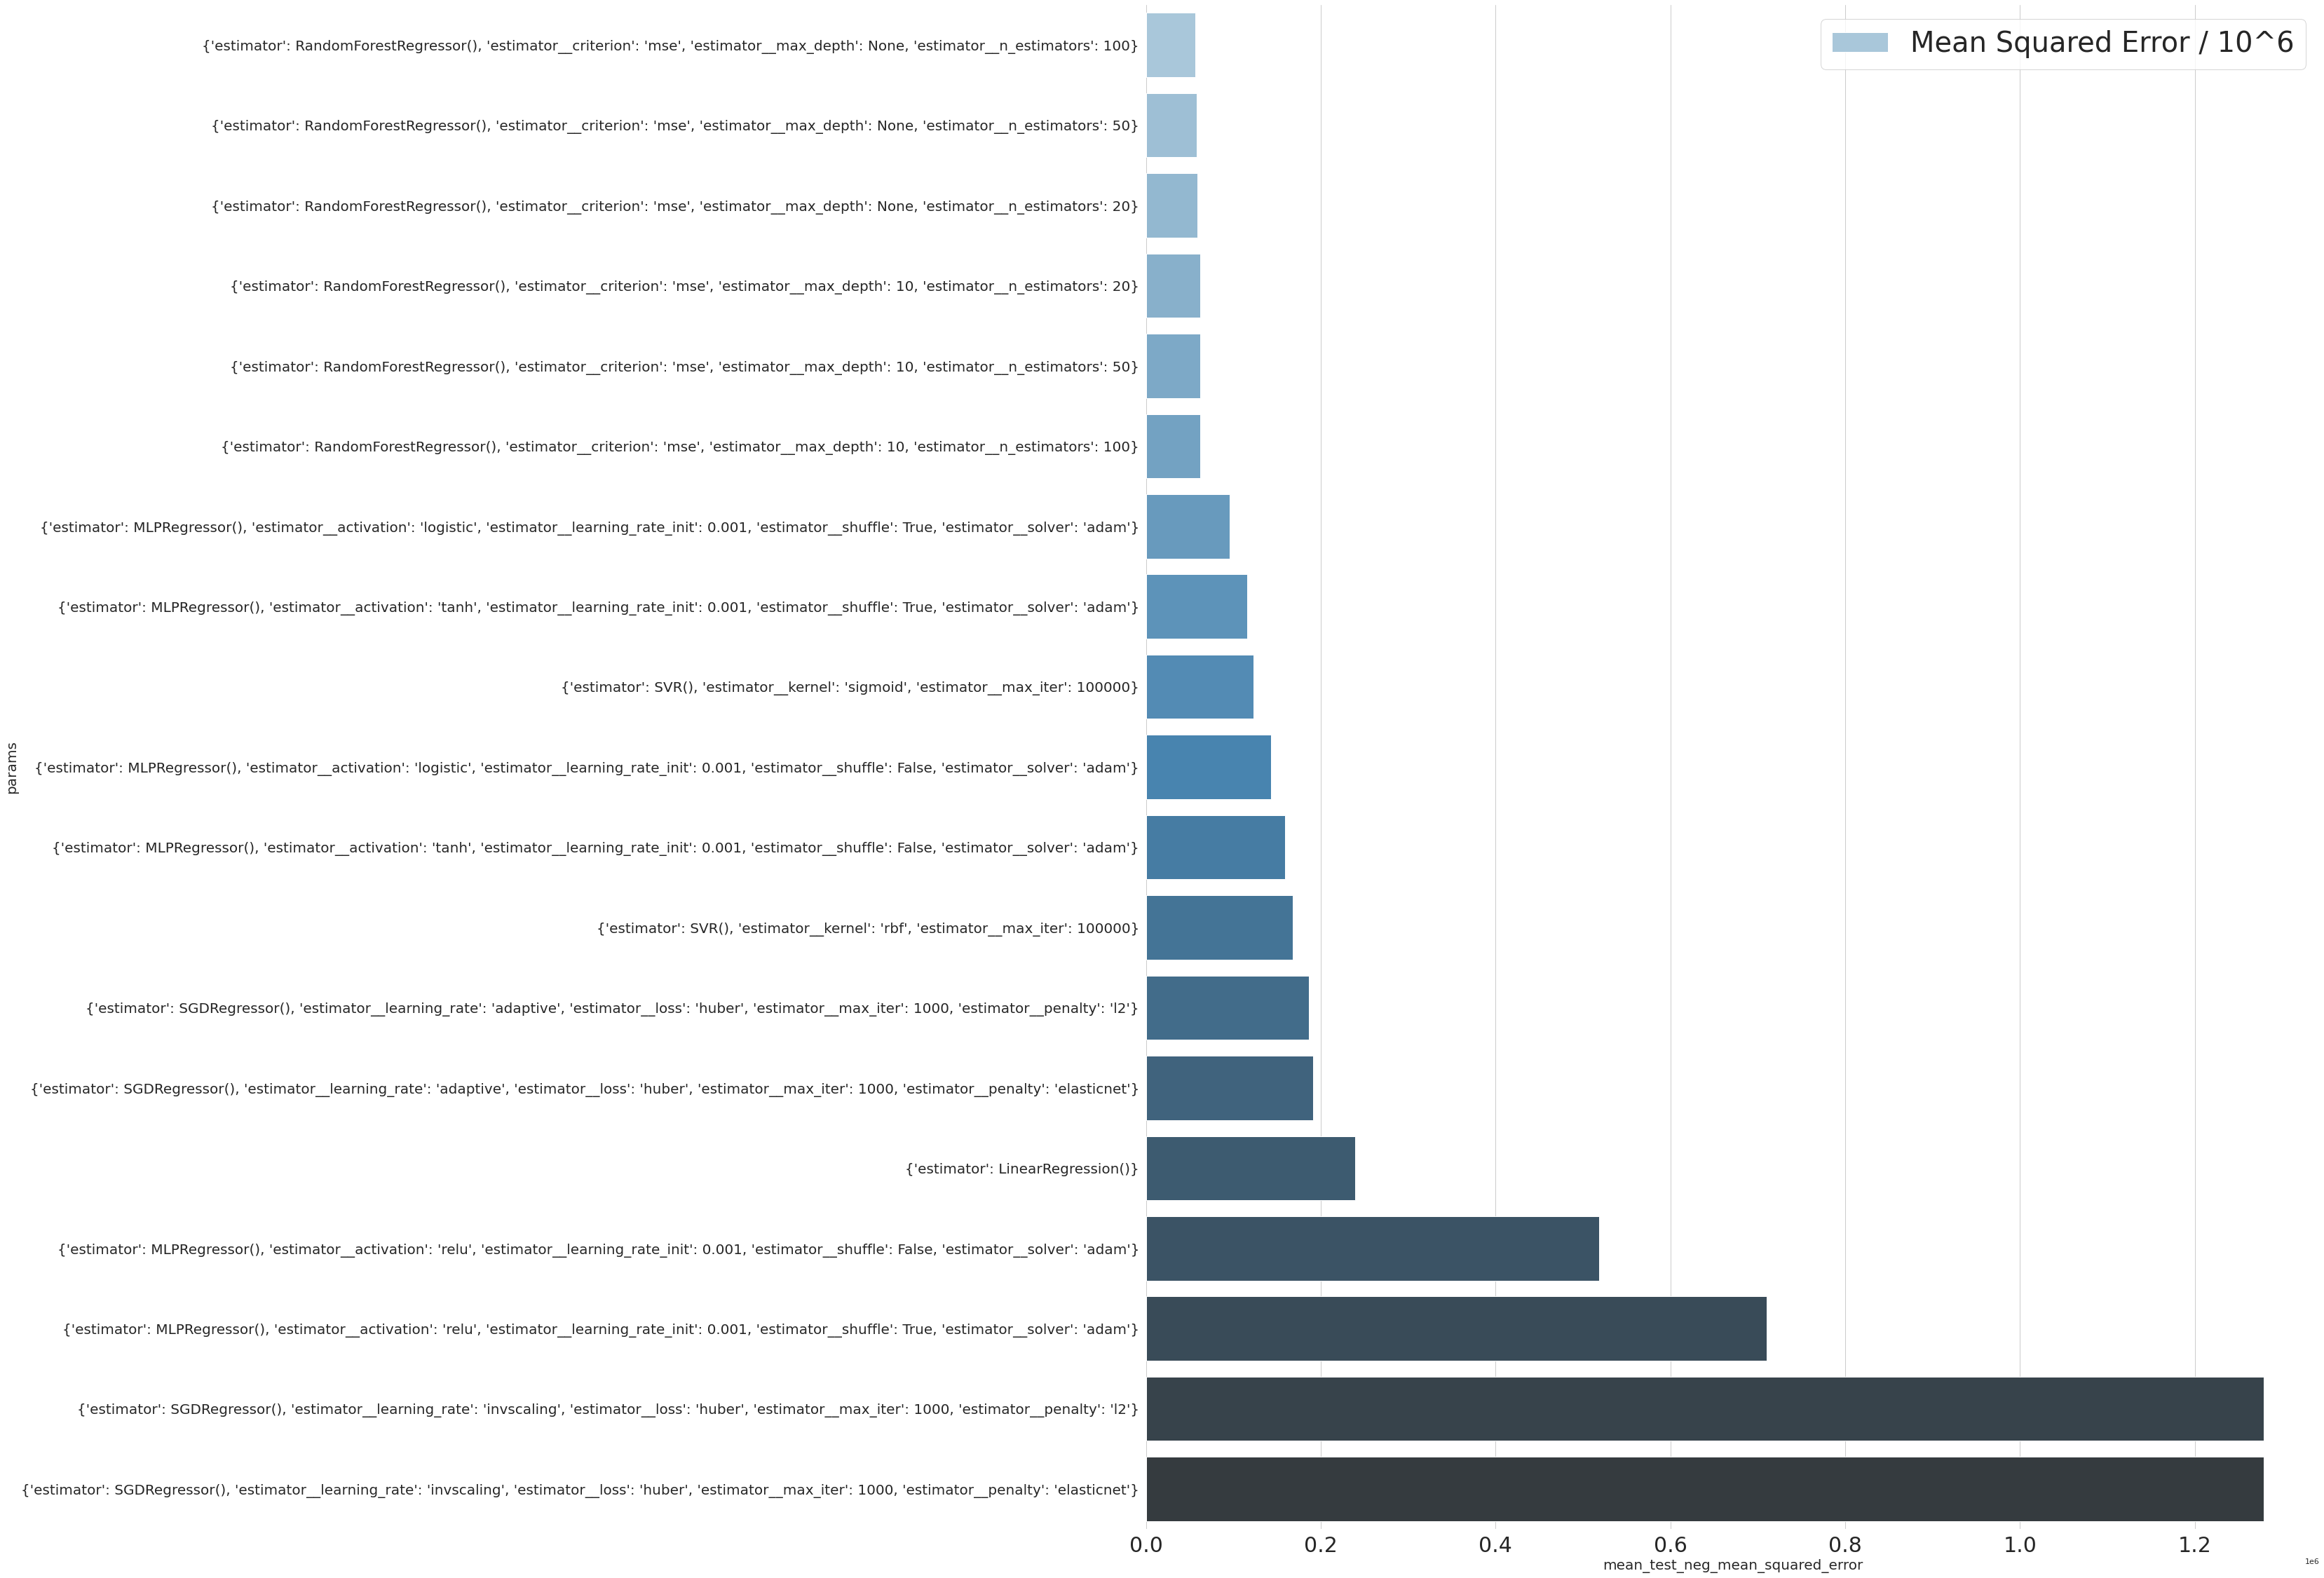

In [22]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(30, 40))
fdf.sort_values(by="mean_test_neg_mean_squared_error",ascending=False,inplace=True)
sns.set_color_codes("pastel")
sns.barplot(x=fdf["mean_test_neg_mean_squared_error"].abs(), y="params", data=fdf,
            label="Mean Squared Error / 10^6", palette="Blues_d")
ax.legend(ncol=1, loc="upper right", frameon=True,fontsize=40)
ax.yaxis.label.set_size(20)
for xtick in ax.xaxis.get_major_ticks():
    xtick.label.set_fontsize(30)
for ytick in ax.yaxis.get_major_ticks():
    ytick.label.set_fontsize(20)
ax.xaxis.label.set_size(20)
sns.despine(left=True, bottom=True)
